# Basic Dataset with  CausalML Meta-learners

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from causalml.inference.tree import UpliftRandomForestClassifier
import warnings

import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseXClassifier
from causalml.inference.nn import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *


from sklift.metrics import auqc, auuc, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
import seaborn as sns
sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline

/home/stemr/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
filepath = '/nas/isg_prodops_work/stemr/2020/2020_03 - Capstone Project/'
basic_df = pd.read_csv(filepath + 'opossum_sim_basic.csv')

In [3]:
#holdout for final performance eval
dev_df, holdout_df = train_test_split(basic_df, test_size=0.1, random_state=847)

In [4]:
holdout_df = holdout_df.reset_index(drop=True)

In [5]:
holdout_df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       0.00       1.00       1.00       0.00       2.48      -0.12   
1       0.00       1.00       1.00       1.00      -0.09      -1.41   
2       0.00       0.00       1.00       1.00      -2.50       2.20   
3       0.00       0.00       0.00       1.00       1.58      -0.48   
4       1.00       1.00       0.00       0.00      -1.21       1.41   

   feature_6  feature_7  feature_8  feature_9  response_cont  exposed  \
0       3.43       1.75      -0.62      -3.28           1.41        0   
1       2.01      -0.74       1.16       0.47          -0.03        0   
2      -0.33       1.77      -0.62       3.59           3.48        1   
3       0.51       1.32      -2.39       0.71           1.42        1   
4      -1.45       2.30       2.19       3.79           3.16        1   

   true_lift  response_cont_prior  conversion  conversion_post     segments  
0       0.00                 1.41           1                1   sure_thing  
1       0.00                -0.03           0                0   lost_cause  
2       1.48                 2.00           1                1   sure_thing  
3       2.12                -0.70           0                1  persuadable  
4       1.71                 1.44           1                1   sure_thing

In [6]:
x_train = dev_df.iloc[:,1:10]
y_train = dev_df['conversion_post']
t_train = dev_df['exposed']

In [7]:
#S Learner Light GBM
learner_s = BaseSRegressor(learner=LGBMRegressor(n_jobs=10))
learner_s.fit(X=x_train, treatment=t_train, y=y_train)
S_lgbm_pred = learner_s.predict(holdout_df.iloc[:,1:10]).flatten()

In [8]:
#S Learner XGB
learner_s = BaseSRegressor(learner=XGBRegressor(n_jobs=10))
learner_s.fit(X=x_train, treatment=t_train, y=y_train)
s_xgb_pred = learner_s.predict(holdout_df.iloc[:,1:10]).flatten()

[19:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [9]:
#T Learner Linear Regression
learner_t = BaseTRegressor(learner=LinearRegression(normalize=True))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_lr_pred = learner_t.predict(holdout_df.iloc[:,1:10]).flatten()

In [10]:
#T LearnerKNearestRegressor
learner_t = BaseTRegressor(learner=KNeighborsRegressor(n_neighbors=10))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_knr_pred = learner_t.predict(holdout_df.iloc[:,1:10]).flatten()

In [11]:
#T Learner Light GBM
learner_t = BaseTRegressor(learner=LGBMRegressor())
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_lgbm_pred = learner_t.predict(holdout_df.iloc[:,1:10]).flatten()

In [12]:
#T Learner XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_xgb_pred = learner_t.predict(holdout_df.iloc[:,1:10]).flatten()

[19:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
#X Learner Linear Regression
learner_x = BaseXRegressor(learner=LinearRegression(normalize=True))
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_lr_pred = learner_x.predict(holdout_df.iloc[:,1:10]).flatten()

In [14]:
#X Learner KNearestRegressor
learner_x = BaseXRegressor(learner=KNeighborsRegressor(n_neighbors=10))
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_knr_pred = learner_x.predict(holdout_df.iloc[:,1:10]).flatten()

In [15]:
#X Learner light gbm
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_lgbm_pred = learner_x.predict(holdout_df.iloc[:,1:10]).flatten()

In [16]:
#X Learner XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_xgb_pred = learner_x.predict(holdout_df.iloc[:,1:10]).flatten()

[19:49:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon.fit(X=x_train, treatment=t_train, y=y_train)
dragon_pred = dragon.predict(holdout_df.iloc[:,1:10]).flatten()

Train on 36000 samples, validate on 9000 samples
Epoch 1/30
36000/36000 [==============================] - 3s 86us/step - loss: 71.9777 - regression_loss: 11.8637 - binary_classification_loss: 44.4490 - treatment_accuracy: 0.4983 - track_epsilon: 0.0080 - val_loss: 70.5585 - val_regression_loss: 11.6227 - val_binary_classification_loss: 44.2938 - val_treatment_accuracy: 0.5056 - val_track_epsilon: 0.0020
Epoch 2/30
36000/36000 [==============================] - 2s 64us/step - loss: 69.5695 - regression_loss: 11.4181 - binary_classification_loss: 44.3884 - treatment_accuracy: 0.5033 - track_epsilon: 9.7793e-04 - val_loss: 68.9522 - val_regression_loss: 11.4079 - val_binary_classification_loss: 44.2831 - val_treatment_accuracy: 0.5049 - val_track_epsilon: 0.0012
Epoch 3/30
36000/36000 [==============================] - 2s 65us/step - loss: 68.4938 - regression_loss: 11.3414 - binary_classification_loss: 44.3707 - treatment_accuracy: 0.5004 - track_epsilon: 0.0012 - val_loss: 68.1584 - va

36000/36000 [==============================] - 4s 97us/step - loss: 65.8755 - regression_loss: 10.7414 - binary_classification_loss: 44.3163 - treatment_accuracy: 0.5022 - track_epsilon: 0.0027 - val_loss: 65.9855 - val_regression_loss: 10.8154 - val_binary_classification_loss: 44.2443 - val_treatment_accuracy: 0.5025 - val_track_epsilon: 0.0045
Epoch 8/300
36000/36000 [==============================] - 2s 64us/step - loss: 65.8788 - regression_loss: 10.7416 - binary_classification_loss: 44.3169 - treatment_accuracy: 0.5055 - track_epsilon: 0.0023 - val_loss: 66.0426 - val_regression_loss: 10.8224 - val_binary_classification_loss: 44.2442 - val_treatment_accuracy: 0.5031 - val_track_epsilon: 0.0086
Epoch 9/300
36000/36000 [==============================] - 2s 59us/step - loss: 65.8714 - regression_loss: 10.7378 - binary_classification_loss: 44.3168 - treatment_accuracy: 0.5061 - track_epsilon: 0.0026 - val_loss: 66.0022 - val_regression_loss: 10.8205 - val_binary_classification_loss: 4

36000/36000 [==============================] - 2s 62us/step - loss: 65.8178 - regression_loss: 10.7159 - binary_classification_loss: 44.3124 - treatment_accuracy: 0.5032 - track_epsilon: 0.0019 - val_loss: 65.9711 - val_regression_loss: 10.8083 - val_binary_classification_loss: 44.2509 - val_treatment_accuracy: 0.4920 - val_track_epsilon: 0.0011
Epoch 30/300
36000/36000 [==============================] - 2s 61us/step - loss: 65.8156 - regression_loss: 10.7139 - binary_classification_loss: 44.3120 - treatment_accuracy: 0.5056 - track_epsilon: 0.0018 - val_loss: 65.9598 - val_regression_loss: 10.8024 - val_binary_classification_loss: 44.2504 - val_treatment_accuracy: 0.4910 - val_track_epsilon: 0.0029
Epoch 31/300
36000/36000 [==============================] - 2s 59us/step - loss: 65.8086 - regression_loss: 10.7141 - binary_classification_loss: 44.3116 - treatment_accuracy: 0.5025 - track_epsilon: 0.0016 - val_loss: 66.0038 - val_regression_loss: 10.8252 - val_binary_classification_loss:

36000/36000 [==============================] - 2s 58us/step - loss: 65.7891 - regression_loss: 10.7036 - binary_classification_loss: 44.3094 - treatment_accuracy: 0.5055 - track_epsilon: 6.7896e-04 - val_loss: 65.9550 - val_regression_loss: 10.8009 - val_binary_classification_loss: 44.2525 - val_treatment_accuracy: 0.4945 - val_track_epsilon: 5.3405e-04
Epoch 52/300
36000/36000 [==============================] - 2s 55us/step - loss: 65.7884 - regression_loss: 10.7031 - binary_classification_loss: 44.3096 - treatment_accuracy: 0.5056 - track_epsilon: 9.9321e-04 - val_loss: 65.9491 - val_regression_loss: 10.7984 - val_binary_classification_loss: 44.2520 - val_treatment_accuracy: 0.4934 - val_track_epsilon: 9.2866e-04
Epoch 53/300
36000/36000 [==============================] - 2s 53us/step - loss: 65.7884 - regression_loss: 10.7035 - binary_classification_loss: 44.3096 - treatment_accuracy: 0.5053 - track_epsilon: 7.3719e-04 - val_loss: 65.9523 - val_regression_loss: 10.7992 - val_binary_

In [18]:
pred_df = pd.merge(holdout_df,pd.DataFrame(S_lgbm_pred, columns=['S_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(s_xgb_pred, columns=['S_XGB']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_xgb_pred, columns=['T_XGB']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_lr_pred, columns=['T_LR']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_knr_pred, columns=['T_KNR']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_lgbm_pred, columns=['T_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_xgb_pred, columns=['X_XGB']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_lr_pred, columns=['X_LR']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_knr_pred, columns=['X_KNR']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_lgbm_pred, columns=['X_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(dragon_pred, columns=['Dragon']), left_index=True, right_index=True) 
pred_df['random_prediction'] = pd.DataFrame(np.random.uniform(-1,1,len(pred_df['conversion_post'])))

In [19]:
pred_df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0.00       1.00       1.00       0.00       2.48      -0.12   
1          0.00       1.00       1.00       1.00      -0.09      -1.41   
2          0.00       0.00       1.00       1.00      -2.50       2.20   
3          0.00       0.00       0.00       1.00       1.58      -0.48   
4          1.00       1.00       0.00       0.00      -1.21       1.41   
...         ...        ...        ...        ...        ...        ...   
4995       0.00       0.00       0.00       1.00      -0.00      -0.69   
4996       1.00       1.00       0.00       1.00      -1.38       0.44   
4997       1.00       1.00       0.00       1.00      -0.98       2.81   
4998       1.00       1.00       1.00       1.00       1.83      -2.56   
4999       1.00       0.00       0.00       1.00      -0.96       0.28   

      feature_6  feature_7  feature_8  feature_9  ...  T_XGB  T_LR  T_KNR  \
0          3.43       1.75      -0.62      -3.28  ...   0.10  0.16   0.10   
1          2.01      -0.74       1.16       0.47  ...   0.25  0.23   0.40   
2         -0.33       1.77      -0.62       3.59  ...   0.23  0.24   0.10   
3          0.51       1.32      -2.39       0.71  ...   0.32  0.28   0.40   
4         -1.45       2.30       2.19       3.79  ...   0.16  0.19   0.00   
...         ...        ...        ...        ...  ...    ...   ...    ...   
4995      -1.65      -0.20      -0.70      -2.07  ...   0.42  0.34   0.50   
4996       0.01       0.15       1.11      -1.81  ...   0.25  0.25   0.40   
4997      -2.61      -1.45       2.24       1.24  ...   0.21  0.20   0.30   
4998      -0.76       2.94      -0.11      -0.73  ...   0.18  0.17  -0.10   
4999       1.01       2.37       2.54       2.25  ...   0.19  0.19   0.00   

      T_LGBM  X_XGB  X_LR X_KNR  X_LGBM  Dragon  random_prediction  
0       0.07   0.14  0.16  0.11    0.11    0.78              -0.70  
1       0.29   0.28  0.23  0.34    0.25    0.97              -0.31  
2       0.25   0.22  0.24  0.17    0.26    0.50               0.70  
3       0.35   0.30  0.28  0.39    0.32    0.00              -0.81  
4       0.10   0.17  0.19  0.09    0.16    0.64              -0.00  
...      ...    ...   ...   ...     ...     ...                ...  
4995    0.45   0.37  0.34  0.42    0.41    0.00              -0.68  
4996    0.16   0.28  0.25  0.42    0.31    0.24              -0.43  
4997    0.24   0.23  0.20  0.33    0.22    0.37              -0.07  
4998    0.16   0.20  0.17  0.04    0.15    0.50               0.52  
4999    0.19   0.17  0.19  0.08    0.16    0.00              -0.26  

[5000 rows x 29 columns]

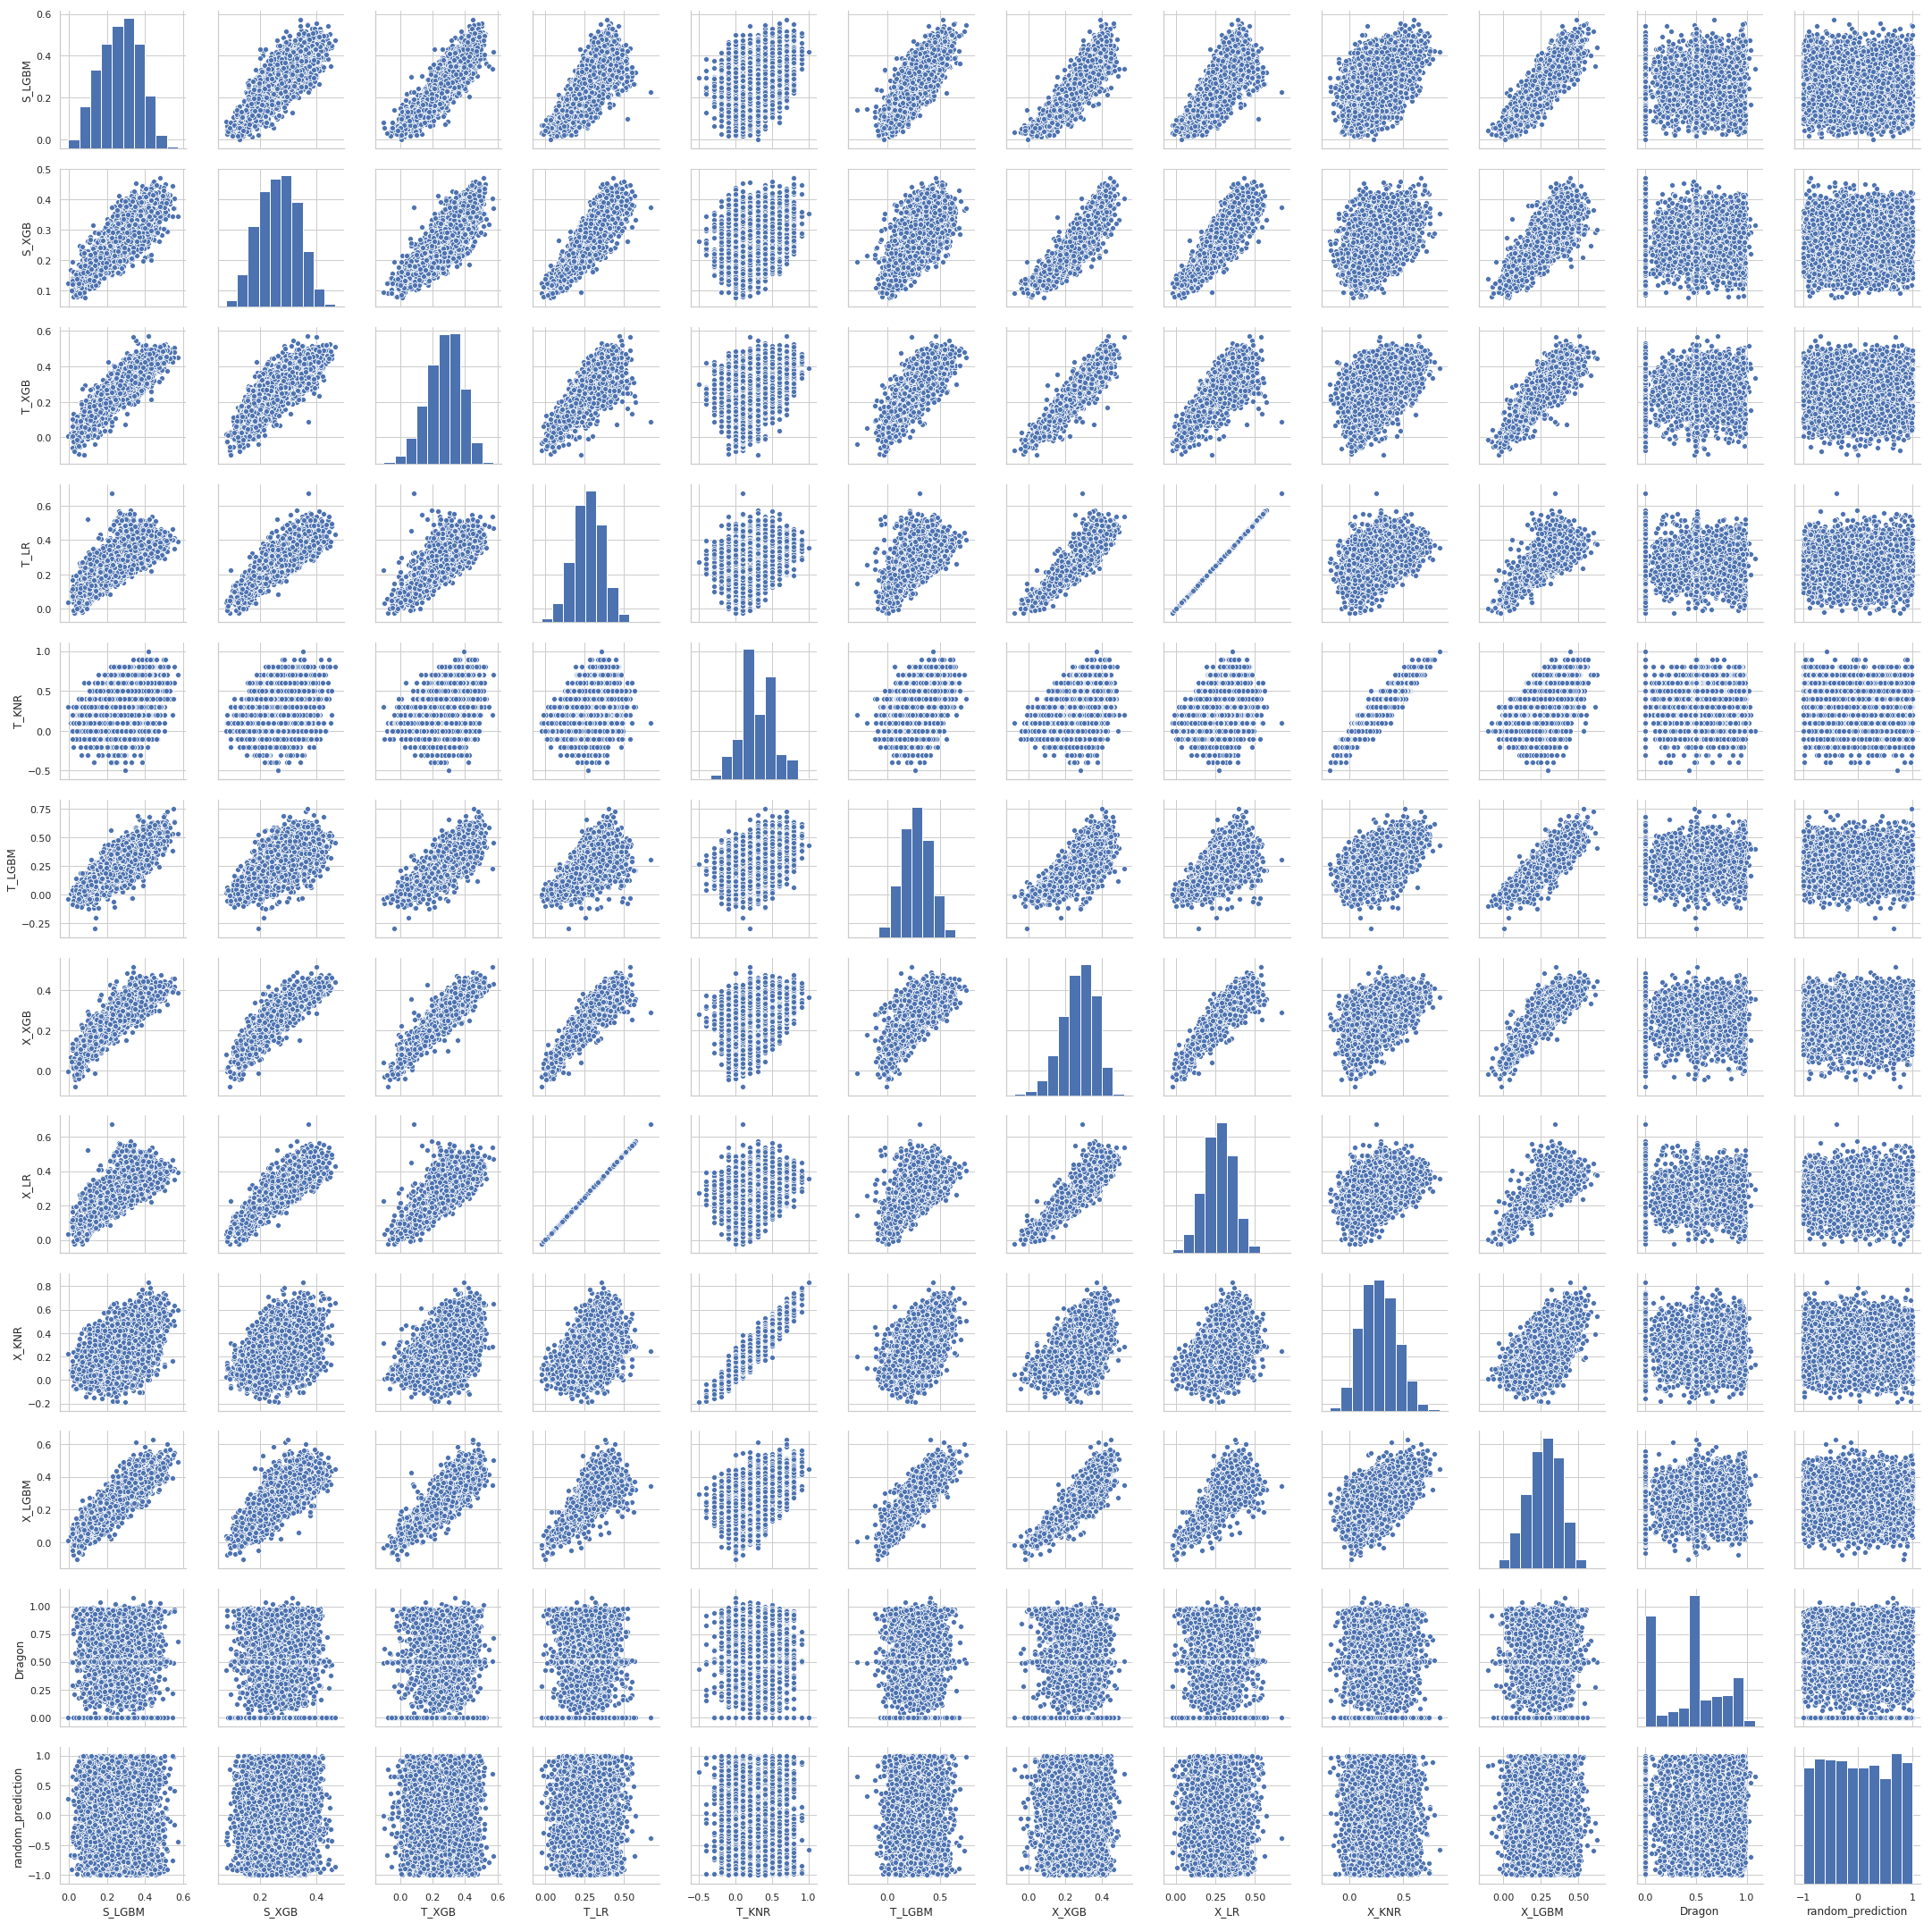

In [20]:
predictions_df = pred_df.iloc[:,-12:]
sns.pairplot(predictions_df);

# Pick Top 3 Based on Holdout AUQC

In [21]:
result_dict = {}
model_list = predictions_df.columns
for i in model_list:
    x = auqc(y_true=pred_df['conversion_post'], uplift=pred_df[i], treatment=pred_df['exposed'])
    result_dict.update({i : x})

In [22]:
pd.DataFrame.from_dict(result_dict, orient='index',columns=['AUQC']).sort_values(by='AUQC', ascending=False)

AUQC
X_LGBM            2153287.19
T_LGBM            2119191.90
S_LGBM            2104498.90
T_LR              2099611.36
X_LR              2099611.36
S_XGB             2095893.53
X_XGB             2082681.62
X_KNR             2076438.06
T_XGB             2067651.74
T_KNR             2027159.75
random_prediction 1715613.14
Dragon            1667060.88

# X_LGBM

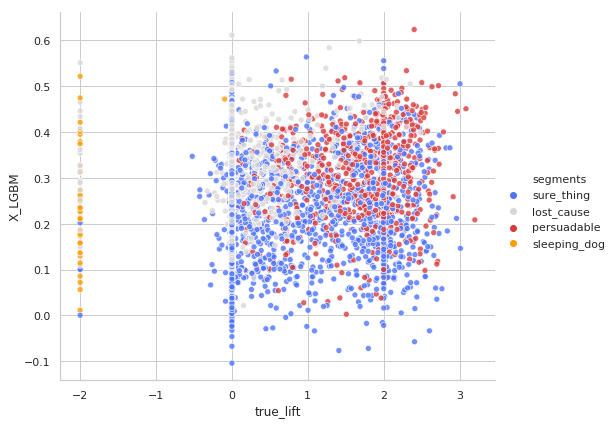

In [23]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="X_LGBM",
            hue="segments",palette=my_pal, data=pred_df, height=6, aspect=1.2, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faad442fdd8>,
      dtype=object)

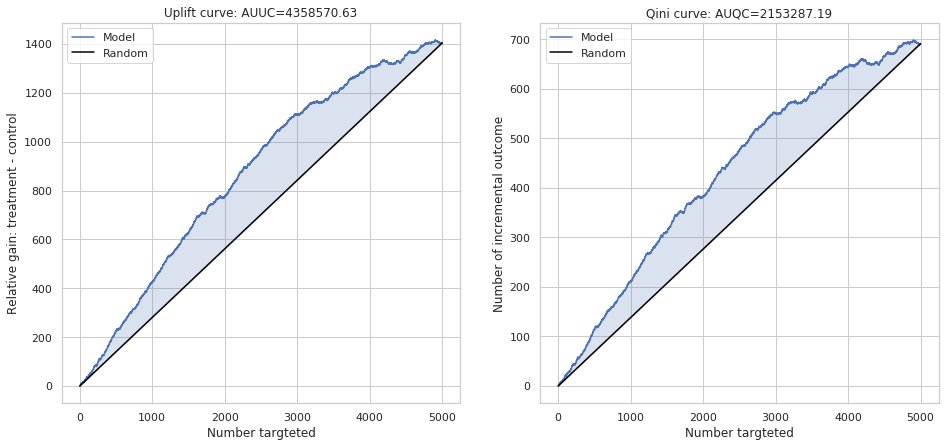

In [24]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['X_LGBM'], treatment=pred_df['exposed'])

In [25]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("X_LGBM",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $10,600
Perfect ROI: $24,000
Improvement from random: 65.62%
Incremental conversions from random: 42
Model to perfect ratio: 44.17%


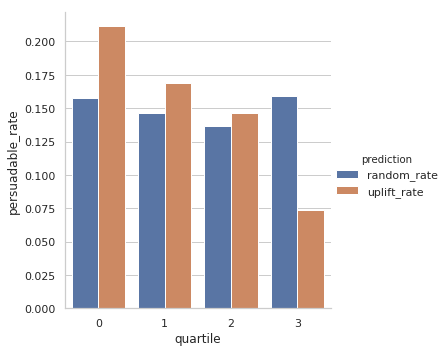

In [26]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['X_LGBM'] > pred_df['X_LGBM'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['X_LGBM'] <= pred_df['X_LGBM'].quantile(q=.75))  & 
                  (pred_df['X_LGBM'] > pred_df['X_LGBM'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['X_LGBM'] <= pred_df['X_LGBM'].quantile(q=.50))  &
                  (pred_df['X_LGBM'] > pred_df['X_LGBM'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['X_LGBM'] <= pred_df['X_LGBM'].quantile(q=.25))  &
                  (pred_df['X_LGBM'] > pred_df['X_LGBM'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

## X_XGB

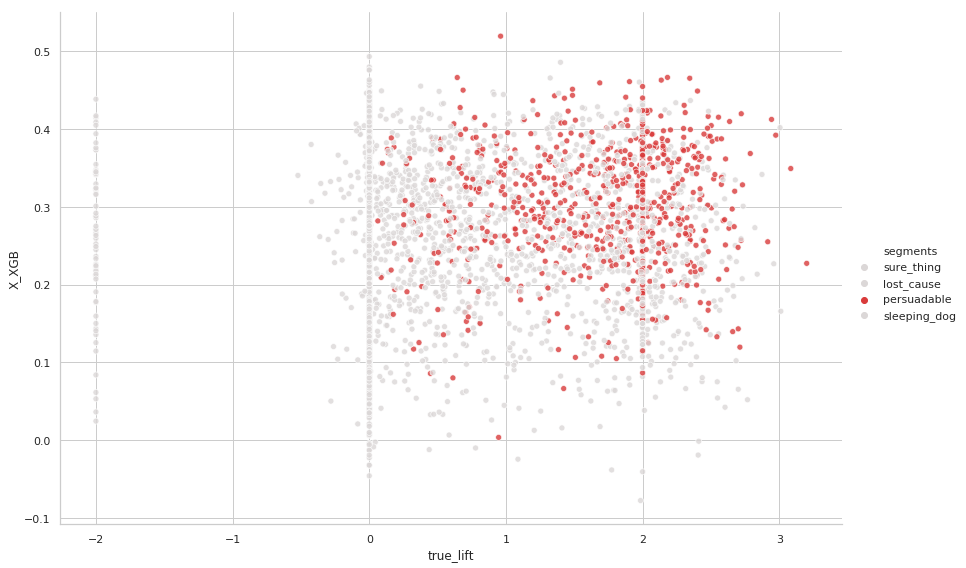

In [27]:
my_pal = {"sure_thing": "#dbd7d7", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#dbd7d7'}
sns.relplot(x="true_lift", y="X_XGB",
            hue="segments",palette=my_pal, data=pred_df, height=8, aspect=1.5, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faab477d780>,
      dtype=object)

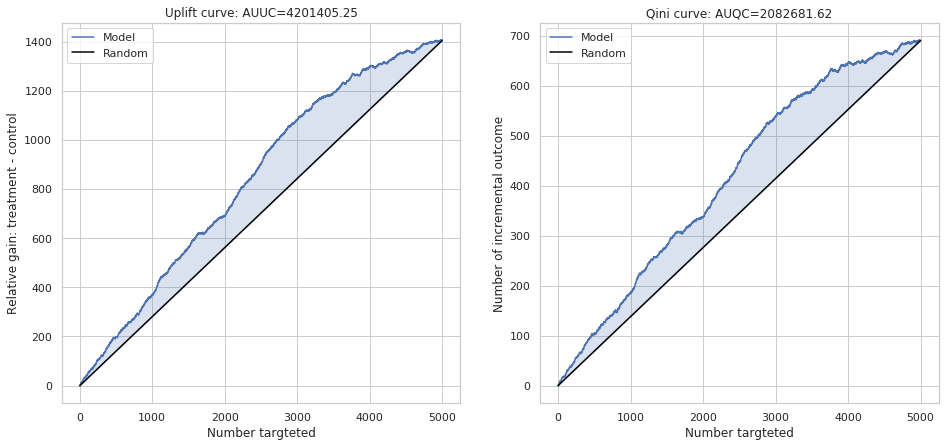

In [28]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['X_XGB'], treatment=pred_df['exposed'])

In [29]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("X_XGB",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $9,100
Perfect ROI: $24,000
Improvement from random: 42.19%
Incremental conversions from random: 27
Model to perfect ratio: 37.92%


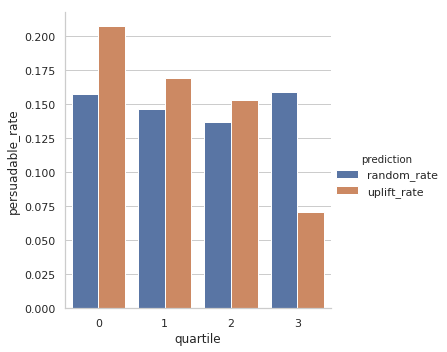

In [30]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['X_XGB'] > pred_df['X_XGB'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['X_XGB'] <= pred_df['X_XGB'].quantile(q=.75))  & 
                  (pred_df['X_XGB'] > pred_df['X_XGB'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['X_XGB'] <= pred_df['X_XGB'].quantile(q=.50))  &
                  (pred_df['X_XGB'] > pred_df['X_XGB'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['X_XGB'] <= pred_df['X_XGB'].quantile(q=.25))  &
                  (pred_df['X_XGB'] > pred_df['X_XGB'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

## T Learner Linear Regression

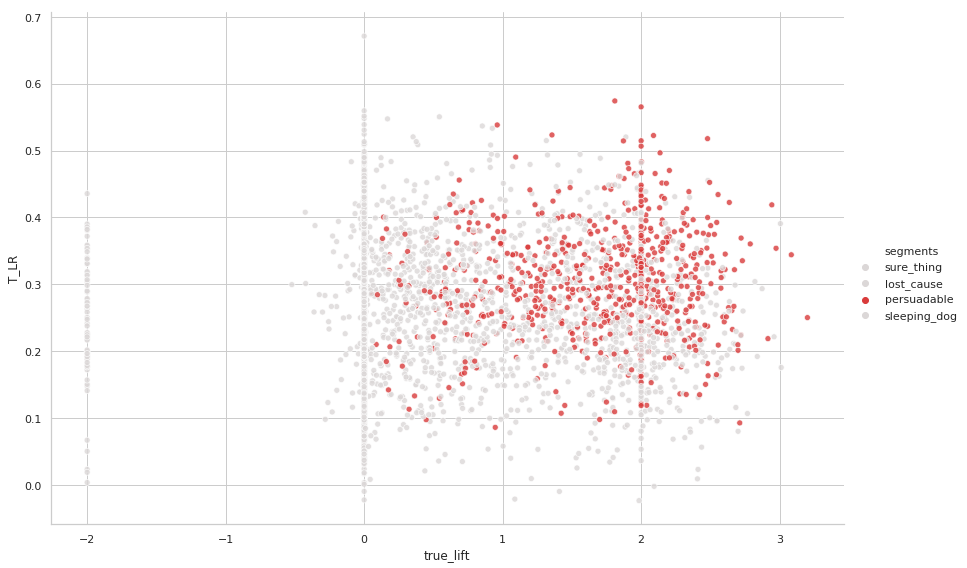

In [31]:
my_pal = {"sure_thing": "#dbd7d7", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#dbd7d7'}
sns.relplot(x="true_lift", y="T_LR",
            hue="segments",palette=my_pal, data=pred_df, height=8, aspect=1.5, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faab452b7b8>,
      dtype=object)

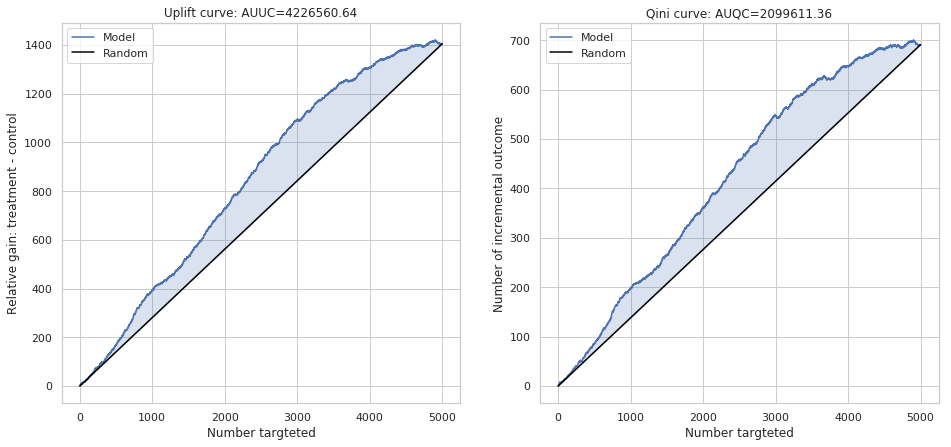

In [32]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['T_LR'], treatment=pred_df['exposed'])

In [33]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("T_LR",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $8,200
Perfect ROI: $24,000
Improvement from random: 28.12%
Incremental conversions from random: 18
Model to perfect ratio: 34.17%


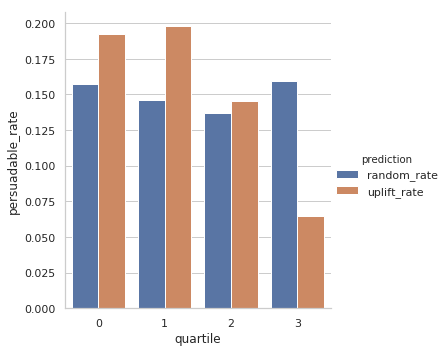

In [34]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.75))  & 
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.50))  &
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.25))  &
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

## T KNR

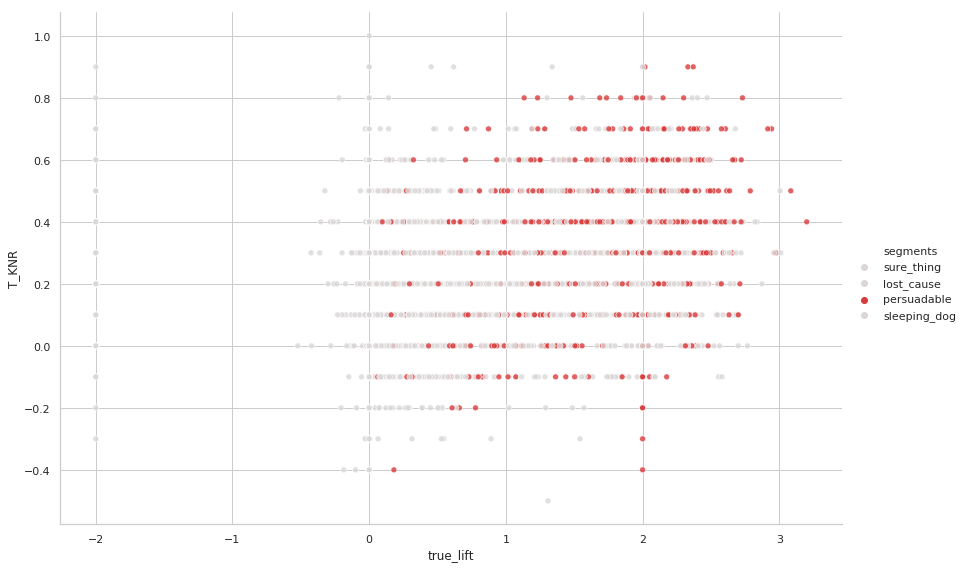

In [35]:
my_pal = {"sure_thing": "#dbd7d7", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#dbd7d7'}
sns.relplot(x="true_lift", y="T_KNR",
            hue="segments",palette=my_pal, data=pred_df, height=8, aspect=1.5, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faab432b048>,
      dtype=object)

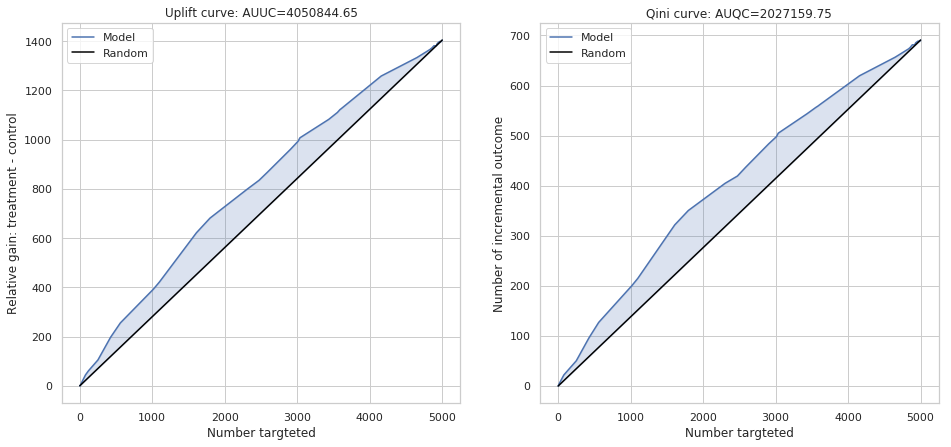

In [36]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['T_KNR'], treatment=pred_df['exposed'])

In [37]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("T_KNR",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $10,900
Perfect ROI: $24,000
Improvement from random: 70.31%
Incremental conversions from random: 45
Model to perfect ratio: 45.42%


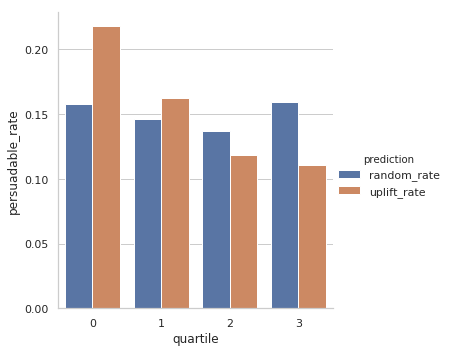

In [38]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['T_KNR'] > pred_df['T_KNR'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['T_KNR'] <= pred_df['T_KNR'].quantile(q=.75))  & 
                  (pred_df['T_KNR'] > pred_df['T_KNR'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['T_KNR'] <= pred_df['T_KNR'].quantile(q=.50))  &
                  (pred_df['T_KNR'] > pred_df['T_KNR'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['T_KNR'] <= pred_df['T_KNR'].quantile(q=.25))  &
                  (pred_df['T_KNR'] > pred_df['T_KNR'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

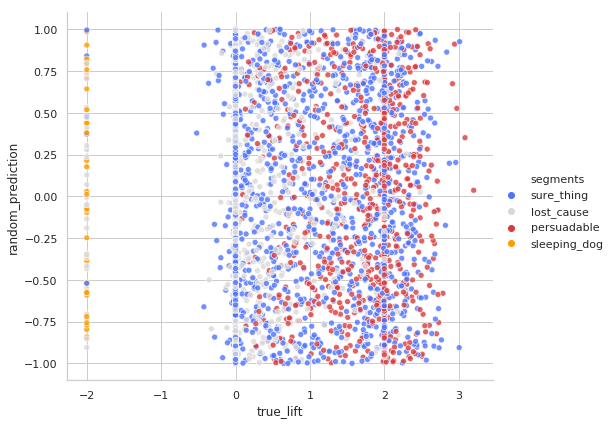

In [49]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="random_prediction",
            hue="segments",palette=my_pal, data=pred_df, height=6, aspect=1.2, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faaf44ca7b8>,
      dtype=object)

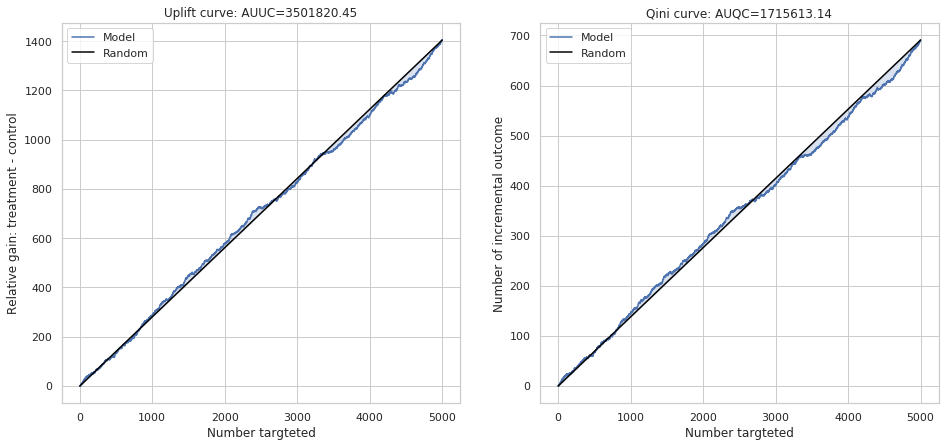

In [43]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['random_prediction'], treatment=pred_df['exposed'])

In [48]:
##Assumptions 
budget = 1000 #budget per 5,000 customers
conversion_profit = 100 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 250
Random ROI: $6,400
Model ROI: $6,400
Perfect ROI: $24,000
Improvement from random: 0.00%
Incremental conversions from random: 0
Model to perfect ratio: 26.67%


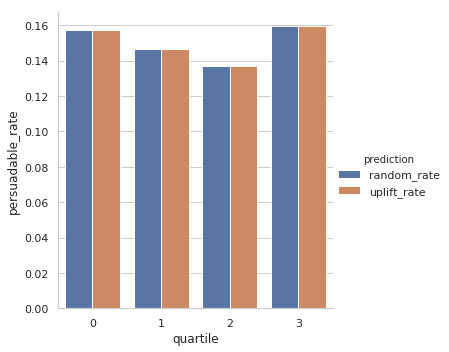

In [45]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');